# Test if Keras's `model.fit` supports incremental learning

## Motivation

from https://github.com/fchollet/keras/issues/68#issuecomment-218023789

jfsantos
>You should not call model.fit, as it does exactly what you said it does: reset and train a model from scratch. ...

fchollet (author of Keras)
> No, no, model.fit does NOT reset the weights of your model. It starts from
the previous state of the model. You can definitely call model.fit multiple
times.

## How to test

Compare the training result between **usual training** and **incremental training**
- **usual training** calls 'model.fit' just once with whole data
- **incremental training** calls 'model.fit' for multiple times with part of entire data

## Test data set
mnist data
- original is 28x28 size image but we convert it into 784 (28x28) dimensional vector here

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
(trainX, trainy), (testX, testy) = mnist.load_data()
trainX, testX = [x.reshape(x.shape[0], x.shape[1] * x.shape[2]) for x in [trainX, testX]]
trainY, testY = [np_utils.to_categorical(y, 10) for y in [trainy, testy]]

scale input value range from [0, 255] to [0, 1]

In [7]:
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX /= 255
testX /= 255

## Model architecture for test

2 layer Multi-Layer-Perceptron
- input layer has 784 unit (784=28x28)
- hidden layer has 100 unit
- output layer has 10 unit (because 10 classes classification)

In [21]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

def gen_model(weight_path=None):
    model = Sequential()
    model.add(Dense(100, input_dim=784))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
    return model

## Prepare helper functions

In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.subplot(221)
    plt.plot(np.arange(nb_epoch), history.history["loss"], color="r", label="loss")
    plt.subplot(222)
    plt.plot(np.arange(nb_epoch), history.history["val_loss"], color="b", label="val_loss")
    plt.subplot(223)
    plt.plot(np.arange(nb_epoch), history.history["acc"], color="g", label="acc")
    plt.subplot(224)
    plt.plot(np.arange(nb_epoch), history.history["val_acc"], color="y", label="val_acc")

def plot_batch_history(loss_history, acc_history):
    history_length = len(loss_history)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.plot(np.arange(history_length), loss_history, color="r", label="loss")
    plt.subplot(122)
    plt.plot(np.arange(history_length), acc_history, color="b", label="acc")
    plt.show()

In [5]:
from sklearn.metrics import classification_report

def evaluate_model(model, testX, testY):
    Yhat = model.predict(testX)
    yhat = np.argmax(Yhat, axis=1)
    print(classification_report(testy, yhat))

# Compare the usual and incremental training result

## Usual training

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       980
          1       0.98      0.99      0.99      1135
          2       0.97      0.98      0.98      1032
          3       0.96      0.97      0.97      1010
          4       0.98      0.98      0.98       982
          5       0.97      0.96      0.97       892
          6       0.97      0.97      0.97       958
          7       0.97      0.97      0.97      1028
          8       0.97      0.96      0.97       974
          9       0.98      0.96      0.97      1009

avg / total       0.97      0.97      0.97     10000



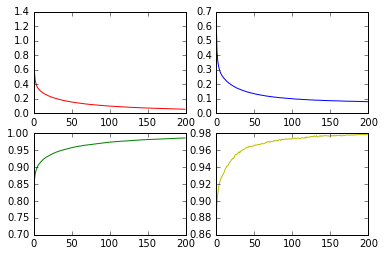

In [8]:
model = gen_model()
nb_epoch = 200
history = model.fit(trainX, trainY, batch_size=128, nb_epoch=nb_epoch, verbose=0, validation_split=0.1)
plot_training_history(history)
evaluate_model(model, testX, testY)

## Incremental training

In [46]:
model = gen_model()
nb_epoch = 200
gen_history = lambda X, Y: model.train_on_batch(np.array([X]), np.array([Y]))
history_holder = [gen_history(trainX[i], trainY[i]) for i in range(len(trainX))]
evaluate_model(model, testX, testY)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.98      0.99      0.98      1135
          2       0.97      0.95      0.96      1032
          3       0.94      0.97      0.95      1010
          4       0.95      0.97      0.96       982
          5       0.94      0.96      0.95       892
          6       0.98      0.94      0.96       958
          7       0.98      0.93      0.96      1028
          8       0.97      0.92      0.94       974
          9       0.93      0.97      0.95      1009

avg / total       0.96      0.96      0.96     10000



metrics is ['loss', 'acc']


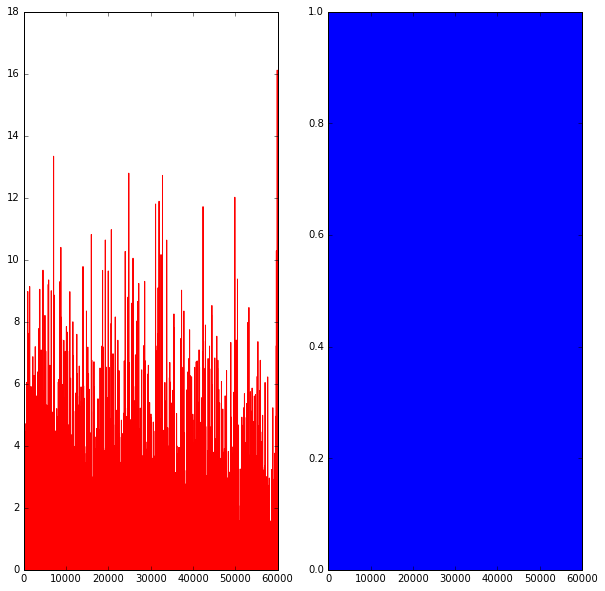

In [88]:
print "metrics is %s" % model.metrics_names
loss = [history_holder[i][0] for i in range(len(history_holder))]
acc = [history_holder[i][1] for i in range(len(history_holder))]
plot_batch_history(loss, acc)

woops...

## See training history by dividing into 100 partition

In [74]:
partition_base = 100
interval = len(acc)/partition_base
acc_partitioned = [acc[i*interval:(i+1)*interval] for i in range(partition_base)]
loss_partitioned = [loss[i*interval:(i+1)*interval] for i in range(partition_base)]

### Partitioned loss history

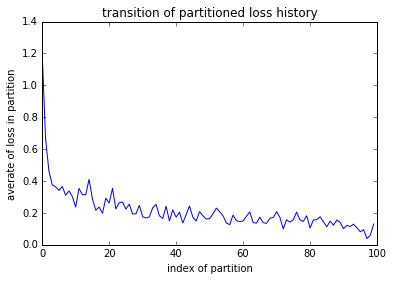

In [90]:
loss_sum_in_each_partition = map(sum, loss_partitioned)
loss_avg_in_each_partition = [1.0*sumval/interval for sumval in loss_sum_in_each_partition]
plt.plot(np.arange(len(loss_avg_in_each_partition)), loss_avg_in_each_partition)
plt.xlabel("index of partition")
plt.ylabel("averate of loss in partition")
plt.title("transition of partitioned loss history")
plt.show()

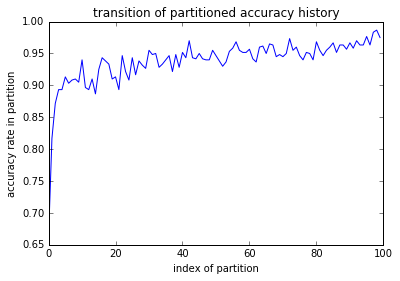

In [89]:
acc_sum_in_each_partition = map(sum, acc_partitioned)
acc_rate_in_each_partition = [1.0*sumval/interval for sumval in acc_sum_in_each_partition]
plt.plot(np.arange(len(acc_rate_in_each_partition)), acc_rate_in_each_partition)
plt.xlabel("index of partition")
plt.ylabel("accuracy rate in partition")
plt.title("transition of partitioned accuracy history")
plt.show()

# Conclustion

Keras's model.fit **supports** incremental learning

when we use incremental learning ...
- we should use `model.train_on_batch` instead of `model.fit`
- the change of loss and accuracy in incremental training is drastic. So we should partition it when observe.